## 3D Layered Surrogate PINN

In [2]:
import os
import time
import gc
import numpy as np
import sciann as sn
import matplotlib.pyplot as plt

from sciann.utils.math import sign, abs, sigmoid, tanh, diff
from exactlayeredfunction import exactlayered
from scipy.optimize import minimize

In [3]:
s, minute, hr, day, year = 1., 60., 60.**2, 24*60.**2, 24*60.**2*365.25
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9

# ----------------------- Constant Parameters-------------------------
Lx = 1*m
Ly = 1*m
Lz = 1*m

p0 = 1.0*Pa
p_star = 1.0*Pa

x_min, x_max = 0., Lx
y_min, y_max = 0., Ly
z_min, z_max = 0., Lz
t_min, t_max = 0., 1.0

In [4]:
# ----------------------- Neural Network Setup -----------------------
sn.reset_session()
sn.set_random_seed(12345)

xd = sn.Variable('xd', dtype='float32')
yd = sn.Variable('yd', dtype='float32')
zd = sn.Variable('zd', dtype='float32')
td = sn.Variable('td', dtype='float32')

cv1 = sn.Variable('cv1', dtype='float32')
cv2 = sn.Variable('cv2', dtype='float32')
cv3 = sn.Variable('cv3', dtype='float32')

pd = sn.Functional('pd', [xd, yd, zd, td, cv1, cv2, cv3], 4*[40], 'tanh') # change layers?

In [5]:
N = 60

xs = np.linspace(0, 1, N)
ys = np.linspace(0, 1, N)
zs = np.linspace(0, 1, N)
ts = np.linspace(0, 1, 21600)

def get_cv(cv1, cv2, cv3, zd):
    return (cv3 * (2/3 <= zd) * (zd <= 1.0)) + (cv2 * (1/3 <= zd) * (zd < 2/3)) + (cv1 * (0 <= zd) * (zd < 1/3)) # without 0 in exact?

In [6]:
# ----------- 3D Terzaghi Layered Problem (Physics) -----------------
pd_x, pd_y, pd_z, pd_t = diff(pd, xd), diff(pd, yd), diff(pd, zd), diff(pd, td)
pd_xx = diff(pd_x, xd)
pd_yy = diff(pd_y, yd)
pd_zz = diff(pd_z, zd)

pd_xy = diff(pd_x, yd)
pd_xyz = diff(pd_xy, zd)

# PDE Equation and BCs
PDE_3D = get_cv(cv1,cv2,cv3,zd)*(pd_xx + pd_yy + pd_zz) - pd_t

bc_ini = (td == t_min) * abs(pd - p0/p_star)
bc_left = (xd == x_min) * abs(pd)
bc_right = (xd == x_max) * abs(pd)
bc_front = (yd == y_min) * abs(pd)
bc_back = (yd == y_max) * abs(pd)
bc_bottom = (zd == z_min) * abs(pd_z)
bc_top = (zd == z_max) * abs(pd_z)

# Continuity of pore pressure and flux at layer interfaces
eps = 1/60 ## changed to from 1e-100

layer3 = (zd == (2/3 + eps)) *  abs(pd) * cv3 
layer2_top = (zd == (2/3 - eps)) * abs(pd) * cv2
layer2_bot = (zd == (1/3 + eps)) * abs(pd) * cv2
layer1 = (zd == (1/3 - eps)) * abs(pd) * cv1

p23 = (zd == 2/3) * abs(pd)
p12 = (zd == 1/3) * abs(pd)

interface_2_3 = (layer2_top + layer3) - p23*(cv3+cv2)
interface_1_2 = (layer2_bot + layer1) - p12*(cv2+cv1)

targets_3D = [sn.Data(pd), sn.PDE(PDE_3D), bc_ini, bc_left, bc_right, bc_front, bc_back, bc_bottom, bc_top, interface_1_2, interface_2_3]

In [7]:
model = sn.SciModel(
    [xd, yd, zd, td, cv1, cv2, cv3],
    targets_3D,
    "mse",
    "Adam",
    load_weights_from = './weights/Terzaghi_3D_Layered_Final_50k.hdf5'
)

---

Note that sections marked with * indicate a requirement of exact solution data for comparison, which require large amounts of memory and data storage. These cells are therefore non-runnable.

## Forward Solution

In [7]:
### -------- Plotting Arrays ---------
N = 90

# Define the evaluation grid
xs = np.linspace(0, 1, N)
ys = np.linspace(0, 1, N)
zs = np.linspace(0, 1, N)
ts = np.linspace(0, 1, 21600)

Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')
x_flat = Xtest.flatten()
y_flat = Ytest.flatten()
z_flat = Ztest.flatten()

mask = (y_flat >= 0.5) & (y_flat <= 1.0)

choices = [
(cv1, cv2, cv3)
for cv1 in (0.015, 0.04, 0.065, 0.09)
for cv2 in (0.015, 0.04, 0.065, 0.09)
for cv3 in (0.015, 0.04, 0.065, 0.09)
]

save_directory = '/rds/general/user/us322/ephemeral/3D Layered Testing New Time'
# This directory is > 1GB! Therefore I am unable to share these files, please
# avoid the cells with comparisons below.

os.makedirs(save_directory, exist_ok=True)

/var/tmp/pbs.176519.pbs-7/ipykernel_111437/4169741974.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: /rds/general/user/us322/home/Final Code/figplots/cv_grid_plot.png


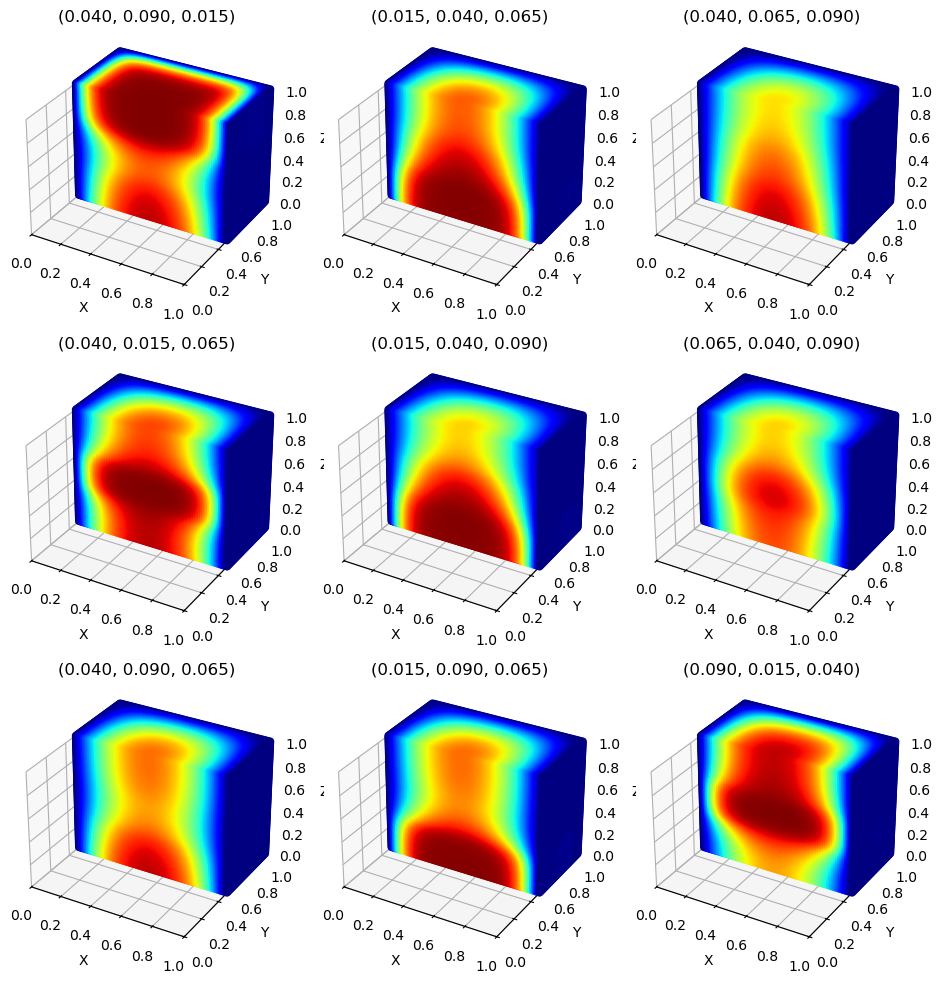

In [43]:
# Define the valid/unique cv choices
valid_choices = list(permutations((0.015, 0.04, 0.065, 0.09), 3))

# Randomly select 9 unique (cv1, cv2, cv3) sets
selected_choices = random.sample(valid_choices, 9)

# Create a 3x3 grid figure
fig, axes = plt.subplots(3, 3, figsize=(12, 12), subplot_kw={'projection': '3d'}, gridspec_kw={'hspace': 0.25, 'wspace': 0.025})

for idx, (cv1, cv2, cv3) in enumerate(selected_choices):
    ax = axes[idx // 3, idx % 3]  # Access the correct subplot

    # Define cv arrays
    cv1_arr = np.full_like(x_flat, cv1)
    cv2_arr = np.full_like(x_flat, cv2)
    cv3_arr = np.full_like(x_flat, cv3)

    # Define test input
    input_test = [x_flat, y_flat, z_flat, np.full_like(x_flat, 0.5), cv1_arr, cv2_arr, cv3_arr]

    # Model evaluation (ensure `p_pred_fixed_time` is reshaped and masked correctly)
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape).flatten()

    # Apply mask for y values between 0.5 and 1
    x_masked, y_masked, z_masked, p_masked = x_flat[mask], y_flat[mask], z_flat[mask], p_pred_fixed_time[mask]

    # Scatter plot with mask applied
    scatter = ax.scatter(x_masked, y_masked, z_masked, c=p_masked, cmap='jet', marker='o', alpha=1.0, vmin=0, vmax=1)

    # Set axis limits and labels
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'({cv1:.3f}, {cv2:.3f}, {cv3:.3f})')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
save_dir = '/rds/general/user/us322/home/Final Code/figplots'
save_path = os.path.join(save_dir, "cv_grid_plot.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

print(f"Saved: {save_path}")

### Compare to Exact Solution *

In [ ]:
# Loop through different time points to plot 3D contours
fig, axs = plt.subplots(len(choices), 3, figsize=(15, 5 * len(choices)), subplot_kw={'projection': '3d'})

difference_plot = True

for i, (cv1_val, cv2_val, cv3_val) in enumerate(choices):
    # Meshgrid for 3D evaluation
    cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
    cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
    cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val

    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv1_arr, cv2_arr, cv3_arr]

    # Evaluate model predictions at the specific time point
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)

    # Flatten data for 3D plotting
    p_flat = p_pred_fixed_time.flatten()
    
    # Plotting PINN result
    scatter_plot_0 = axs[i, 0].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=p_flat[mask], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
    axs[i, 0].set_title(f'PINN Solution for ({cv1_val},{cv2_val},{cv3_val})')
    axs[i, 0].set_xlabel('X')
    axs[i, 0].set_ylabel('Y')
    axs[i, 0].set_zlabel('Z')
    axs[i, 0].set_xlim([0, 1])
    axs[i, 0].set_ylim([0, 1])
    axs[i, 0].set_zlim([0, 1])
    fig.colorbar(scatter_plot_0, ax=axs[i, 0], shrink=0.8, pad=0.15)

    if difference_plot:
        u_t = np.load(os.path.join(save_directory, f'u_t_{cv1_val}_{cv2_val}_{cv3_val}_{N}.npy'))
        
        # Calculate the difference/errors
        difference = np.abs(p_pred_fixed_time - u_t)/np.abs(np.max(u_t))
        u_flat = u_t.flatten()
        d_flat = difference.flatten()
        
        # Plotting exact solution
        scatter_plot_1 = axs[i, 1].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=u_flat[mask], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
        axs[i, 1].set_title(f'Exact Solution for ({cv1_val},{cv2_val},{cv3_val})')
        axs[i, 1].set_xlabel('X')
        axs[i, 1].set_ylabel('Y')
        axs[i, 1].set_zlabel('Z')
        axs[i, 1].set_xlim([0, 1])
        axs[i, 1].set_ylim([0, 1])
        axs[i, 1].set_zlim([0, 1])
        fig.colorbar(scatter_plot_1, ax=axs[i, 1], shrink=0.8, pad=0.15)
    
        # Plotting difference/errors
        scatter_plot_2 = axs[i, 2].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=d_flat[mask], cmap='jet', marker='o', alpha=1.)
        axs[i, 2].set_title(f'Rel. Error for cv = ({cv1_val},{cv2_val},{cv3_val})')
        axs[i, 2].set_xlabel('X')
        axs[i, 2].set_ylabel('Y')
        axs[i, 2].set_zlabel('Z')
        axs[i, 2].set_xlim([0, 1])
        axs[i, 2].set_ylim([0, 1])
        axs[i, 2].set_zlim([0, 1])
        fig.colorbar(scatter_plot_2, ax=axs[i, 2], shrink=0.8, pad=0.15)

        del u_t

        gc.collect()

plt.savefig(f"./plots/3D-Contour-Plots_Final_{epochs}.png")
plt.show()

### Error Analysis

In [20]:
N = 3
cv1_val = cv2_val = cv3_val = 0.055
t_index = int(0.5*(21600-1))

# Define the evaluation grid
xs = np.linspace(0, 1, N)
ys = np.linspace(0, 1, N)
zs = np.linspace(0, 1, N)
ts = np.linspace(0, 1, 21600)

Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')
x_flat = Xtest.flatten()
y_flat = Ytest.flatten()
z_flat = Ztest.flatten()

cv1_list = cv2_list = cv3_list = np.linspace(0.01,0.1,50)

RMSE_arr1, RMSE_arr2, RMSE_arr3 = [], [], []

# Start the timer
start_time = time.time()

with open(f"RMSE_log_{N}.txt", "a") as log_file:
    # Loop for cv1_list
    for i, cv1_iter in enumerate(cv1_list):
        loop_start_time = time.time()
    
        cv1_arr = np.ones_like(Xtest.flatten()) * cv1_iter
        cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
        cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val
    
        input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv1_arr, cv2_arr, cv3_arr]
        pd_eval = pd.eval(input_test).reshape(Xtest.shape)
    
        u_t = exactlayered(N, cv1_iter, cv2_val, cv3_val)[:,:,:,t_index]
    
        RMSE1 = np.mean((pd_eval - u_t)**2)
    
        del u_t, pd_eval
        gc.collect()
    
        RMSE_arr1.append(RMSE1)
    
        # Estimate remaining time
        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / (i + 1)
        remaining_iterations = (len(cv1_list) - (i + 1)) + len(cv2_list) + len(cv3_list)
        remaining_time = avg_time_per_iteration * remaining_iterations
    
        print(f"cv1 loop - Time taken: {time.time() - loop_start_time:.2f} seconds, Estimated time remaining: {remaining_time / 60:.2f} minutes")
        log_file.write(f"cv1 loop - Time taken: {time.time() - loop_start_time:.2f} seconds, Estimated time remaining: {remaining_time / 60:.2f} minutes\n")
        log_file.flush()  # Force immediate write to the file

    # Repeat for cv2_list
    for i, cv2_iter in enumerate(cv2_list):
        loop_start_time = time.time()
    
        cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
        cv2_arr = np.ones_like(Xtest.flatten()) * cv2_iter
        cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val
    
        input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv1_arr, cv2_arr, cv3_arr]
        pd_eval = pd.eval(input_test).reshape(Xtest.shape)
    
        u_t = exactlayered(N, cv1_val, cv2_iter, cv3_val)[:,:,:,t_index]
    
        RMSE2 = np.mean((pd_eval - u_t)**2)
    
        del u_t, pd_eval
        gc.collect()
    
        RMSE_arr2.append(RMSE2)
    
        # Estimate remaining time
        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / (len(cv1_list) + i + 1)
        remaining_iterations = (len(cv2_list) - (i + 1)) + len(cv3_list)
        remaining_time = avg_time_per_iteration * remaining_iterations
    
        print(f"cv2 loop - Time taken: {time.time() - loop_start_time:.2f} seconds, Estimated time remaining: {remaining_time / 60:.2f} minutes")
        log_file.write(f"cv2 loop - Time taken: {time.time() - loop_start_time:.2f} seconds, Estimated time remaining: {remaining_time / 60:.2f} minutes\n")
        log_file.flush()  # Force immediate write to the file

    # Repeat for cv3_list
    for i, cv3_iter in enumerate(cv3_list):
        loop_start_time = time.time()
    
        cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
        cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
        cv3_arr = np.ones_like(Xtest.flatten()) * cv3_iter
    
        input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv1_arr, cv2_arr, cv3_arr]
        pd_eval = pd.eval(input_test).reshape(Xtest.shape)
    
        u_t = exactlayered(N, cv1_val, cv2_val, cv3_iter)[:,:,:,t_index]
        
        RMSE3 = np.mean((pd_eval - u_t)**2)
    
        del u_t, pd_eval
        gc.collect()
    
        RMSE_arr3.append(RMSE3)
    
        # Estimate remaining time
        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / (len(cv1_list) + len(cv2_list) + i + 1)
        remaining_iterations = len(cv3_list) - (i + 1)
        remaining_time = avg_time_per_iteration * remaining_iterations
    
        print(f"cv3 loop - Time taken: {time.time() - loop_start_time:.2f} seconds, Estimated time remaining: {remaining_time / 60:.2f} minutes")
        log_file.write(f"cv3 loop - Time taken: {time.time() - loop_start_time:.2f} seconds, Estimated time remaining: {remaining_time / 60:.2f} minutes\n")
        log_file.flush()  # Force immediate write to the file

np.savez(f'./rmse/RMSE_data_{N}.npz', RMSE_arr1=RMSE_arr1, RMSE_arr2=RMSE_arr2, RMSE_arr3=RMSE_arr3)

plt.plot(cv1_list, RMSE_arr1, label='cv1')
plt.plot(cv2_list, RMSE_arr2, label='cv2')
plt.plot(cv3_list, RMSE_arr3, label='cv3')

# Adding vertical bars
plt.axvline(x=0.01, color='blue', linestyle='--')
plt.axvline(x=0.055, color='blue', linestyle='--')
plt.axvline(x=0.10, color='blue', linestyle='--')

plt.legend()
plt.xlabel('cv1/cv2/cv3')
plt.ylabel('RMSE')
plt.grid()
plt.savefig('./rmse/ContinuousRMSE.png',dpi=600)
plt.show()

Simulation completed for (0.01, 0.055, 0.055)
cv1 loop - Time taken: 0.40 seconds, Estimated time remaining: 0.99 minutes
Simulation completed for (0.01183673469387755, 0.055, 0.055)
cv1 loop - Time taken: 0.39 seconds, Estimated time remaining: 1.00 minutes
Simulation completed for (0.013673469387755103, 0.055, 0.055)
cv1 loop - Time taken: 0.40 seconds, Estimated time remaining: 0.99 minutes
Simulation completed for (0.015510204081632653, 0.055, 0.055)
cv1 loop - Time taken: 0.40 seconds, Estimated time remaining: 0.98 minutes
Simulation completed for (0.017346938775510204, 0.055, 0.055)
cv1 loop - Time taken: 0.40 seconds, Estimated time remaining: 0.97 minutes
Simulation completed for (0.019183673469387756, 0.055, 0.055)
cv1 loop - Time taken: 0.40 seconds, Estimated time remaining: 0.96 minutes
Simulation completed for (0.02102040816326531, 0.055, 0.055)
cv1 loop - Time taken: 0.40 seconds, Estimated time remaining: 0.95 minutes
Simulation completed for (0.02285714285714286, 0.055

KeyboardInterrupt: 

## Execution Times

In [ ]:
# Define the range of N values
N_values = range(10, 1001)  # N from 10 to 250 in integer steps
execution_times = []

for N in N_values:
    # Define the evaluation grid
    xs = np.linspace(0, 1, N)
    ys = np.linspace(0, 1, N)
    zs = np.linspace(0, 1, N)
    ts = np.linspace(0, 1, 21600)

    Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')
    x_flat = Xtest.flatten()
    y_flat = Ytest.flatten()
    z_flat = Ztest.flatten()

    mask = (y_flat >= 0.5) & (y_flat <= 1.0)

    cv1_val, cv2_val, cv3_val = 0.02, 0.04, 0.07

    # Prepare inputs for the model
    cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
    cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
    cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val

    input_test = [
        Xtest.flatten(),
        Ytest.flatten(),
        Ztest.flatten(),
        np.full_like(Xtest.flatten(), ts[0]),  # Example t_index = 0
        cv1_arr,
        cv2_arr,
        cv3_arr
    ]
    
    # Measure the time taken to execute pd.eval
    start_time = time.time()
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)
    execution_times.append(time.time() - start_time)

    del p_pred_fixed_time
    gc.collect()
    
    print(f'{N} finished')

Fit parameters: a=0.000000, b=0.002925


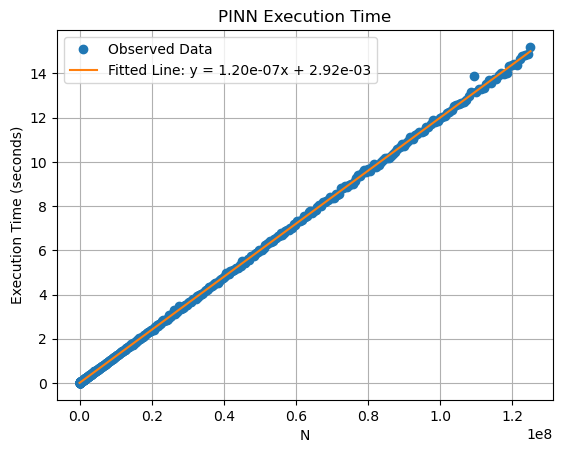

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Load execution_times from the text file
# execution_times = np.loadtxt('execution_times.txt')
N_vals = [n**3 for n in range(10, 501)]

# Perform a linear fit
def linear_fit(x, a, b):
    return a * x + b

# Fit the data
params, _ = curve_fit(linear_fit, N_vals, execution_times)

# Generate the fitted times using the linear model
fitted_times = linear_fit(np.array(N_vals), *params)

# Print the fit parameters
print(f"Fit parameters: a={params[0]:.6f}, b={params[1]:.6f}")

# Plot the data and fitted curve
plt.plot(N_vals, execution_times, 'o', label='Observed Data')
plt.plot(N_vals, fitted_times, '-', label=f'Fitted Line: y = {params[0]:.2e}x + {params[1]:.2e}')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.title('PINN Execution Time')
plt.legend()
plt.grid(True)
plt.savefig("./plots/ExecutionTime.png", dpi=600, bbox_inches='tight')

In [ ]:
# Create the figure and primary axis
fig, ax1 = plt.subplots()

# Plot the data and fitted curve
ax1.plot(N_vals, execution_times, 'o', label='Observed Data')
ax1.plot(N_vals, fitted_times, '-', label=f'Fitted Line: y = {params[0]:.2e}x + {params[1]:.2e}')
ax1.set_xlabel('N (Number of Samples)')
ax1.set_ylabel('Execution Time (seconds)')
ax1.legend()
ax1.grid(True)

# Modify secondary axis functions to ignore grid sizes below 200
def N_to_n(N):
    n = np.cbrt(N)
    return np.where(n >= 200, n, np.nan)  # Use np.where for array handling

def n_to_N(n):
    return np.where(n >= 200, n**3, np.nan)  # Use np.where for array handling
    
secax = ax1.secondary_xaxis('top', functions=(N_to_n, n_to_N))
secax.set_xlabel('n (Grid Size)')

# Save the plot
plt.savefig("./plots/ExecutionTime_with_n.png", dpi=600, bbox_inches='tight')
plt.show()

In [21]:
time_to_1bil = params[0]*1000**3 + params[1]

print(f'{time_to_1bil/60:.2f} mins')

2.00 mins


## 3D Animation of cv1, cv2, cv3

MovieWriter ffmpeg unavailable; using Pillow instead.


Frame 1.0/150.0, Predicted time remaining: 1.67 seconds
Frame 1.0/150.0, Predicted time remaining: 17.50 seconds
Frame 2.0/150.0, Predicted time remaining: 817.84 seconds
Frame 3.0/150.0, Predicted time remaining: 1072.31 seconds
Frame 4.0/150.0, Predicted time remaining: 1203.44 seconds
Frame 5.0/150.0, Predicted time remaining: 1274.46 seconds
Frame 6.0/150.0, Predicted time remaining: 1320.25 seconds
Frame 7.0/150.0, Predicted time remaining: 1348.25 seconds
Frame 8.0/150.0, Predicted time remaining: 1367.59 seconds
Frame 9.0/150.0, Predicted time remaining: 1380.87 seconds
Frame 10.0/150.0, Predicted time remaining: 1389.96 seconds
Frame 11.0/150.0, Predicted time remaining: 1394.24 seconds
Frame 12.0/150.0, Predicted time remaining: 1394.28 seconds
Frame 13.0/150.0, Predicted time remaining: 1394.43 seconds
Frame 14.0/150.0, Predicted time remaining: 1391.67 seconds
Frame 15.0/150.0, Predicted time remaining: 1388.44 seconds
Frame 16.0/150.0, Predicted time remaining: 1384.51 seco

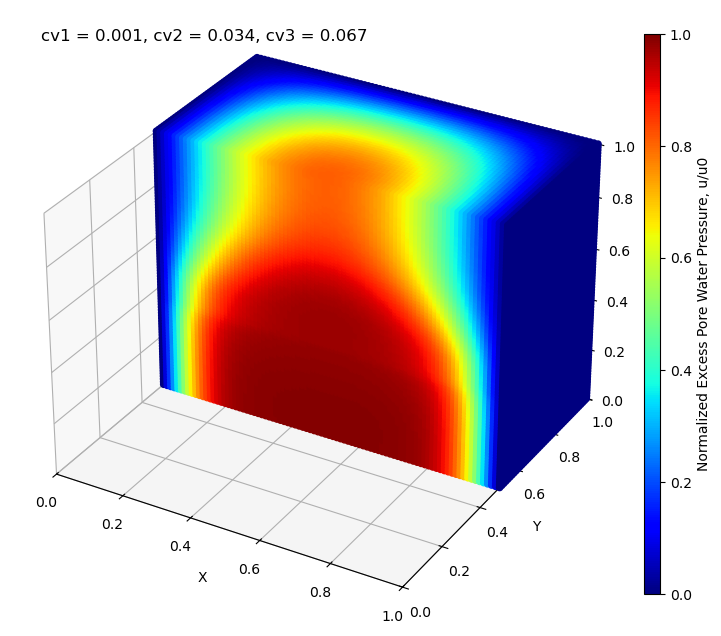

In [20]:
import time
from matplotlib.animation import FuncAnimation

N = 90 # Grid number
Nx = Ny = Nz = N
Nt = 21600

v_min, v_max = 0., 1.0 # Change for mesh-free evaluation

xs = np.linspace(v_min, v_max, N)
ys = np.linspace(v_min, v_max, N)
zs = np.linspace(v_min, v_max, N)
ts = np.linspace(t_min, t_max, Nt)

# Meshgrid for 3D evaluation
Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')

# Flatten data for 3D plotting
x_flat = Xtest.flatten()
y_flat = Ytest.flatten()
z_flat = Ztest.flatten()

# Initialize figure and axis
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})

# Initial plot (this will be updated in each frame)
scatter = ax.scatter([], [], [], c=[], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)

# Set axis limits
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the total number of frames and interval for desired FPS
fps = 30
t_val = 5.0
num_frames = fps * t_val
interval = 1000 / fps

start_time = time.time()

# Add a text label for time (you may want to use 3D coordinates to ensure visibility in a 3D plot)
cv_text = ax.text2D(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, color='black')

# Define update function for animation
def update(frame):
    # Calculate time elapsed per frame
    elapsed_time = time.time() - start_time
    average_time_per_frame = elapsed_time / (frame + 1)
    
    # Estimate remaining time
    remaining_time = average_time_per_frame * (num_frames - frame - 1)

    # Print predicted time remaining
    progress_message = f"Frame {frame+1}/{num_frames}, Predicted time remaining: {remaining_time:.2f} seconds"

    print(progress_message)

    t_index = int(0.5 * (21600-1)) # using t = 0.5 to plot.
    
    cv1_val = 0.001 + (0.10 - 0.001) * (frame / num_frames)
    cv2_val = 0.001 + (0.10 - 0.001) * ((frame + num_frames / 3) % num_frames / num_frames)
    cv3_val = 0.001 + (0.10 - 0.001) * ((frame + 2 * num_frames / 3) % num_frames / num_frames)
    
    cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
    cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
    cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val

    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(),  ts[t_index]), cv1_arr, cv2_arr, cv3_arr]

    # Evaluate model predictions at the specific time point
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)

    p_flat = p_pred_fixed_time.flatten()
    
    mask = (y_flat >= 0.5) & (y_flat <= 1.0)
    
    # Update scatter plot data
    scatter._offsets3d = x_flat[mask], y_flat[mask], z_flat[mask]
    scatter.set_array(p_flat[mask])
    
    # Update the cv text
    current_cv = f'cv1 = {cv1_val:.3f}, cv2 = {cv2_val:.3f}, cv3 = {cv3_val:.3f}'
    cv_text.set_text(current_cv)
    
    return scatter, current_cv

# Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(0, num_frames), interval=interval, blit=False)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(scatter, cax=cbar_ax, label='Normalized Excess Pore Water Pressure, u/u0')

# Save or display the animation
ani.save(f"3D-Animation_{N}_60fps.gif", dpi=80)

print(f'Animation completed.')

## 3D Animation With Time

MovieWriter ffmpeg unavailable; using Pillow instead.


Frame 1.0/150.0, Predicted time remaining: 1.64 seconds
Frame 1.0/150.0, Predicted time remaining: 17.21 seconds
Frame 2.0/150.0, Predicted time remaining: 846.40 seconds
Frame 3.0/150.0, Predicted time remaining: 1101.28 seconds
Frame 4.0/150.0, Predicted time remaining: 1227.26 seconds
Frame 5.0/150.0, Predicted time remaining: 1298.86 seconds
Frame 6.0/150.0, Predicted time remaining: 1340.65 seconds
Frame 7.0/150.0, Predicted time remaining: 1367.97 seconds
Frame 8.0/150.0, Predicted time remaining: 1388.10 seconds
Frame 9.0/150.0, Predicted time remaining: 1401.20 seconds
Frame 10.0/150.0, Predicted time remaining: 1409.37 seconds
Frame 11.0/150.0, Predicted time remaining: 1411.39 seconds
Frame 12.0/150.0, Predicted time remaining: 1411.92 seconds
Frame 13.0/150.0, Predicted time remaining: 1410.28 seconds
Frame 14.0/150.0, Predicted time remaining: 1406.73 seconds
Frame 15.0/150.0, Predicted time remaining: 1402.90 seconds
Frame 16.0/150.0, Predicted time remaining: 1398.96 seco

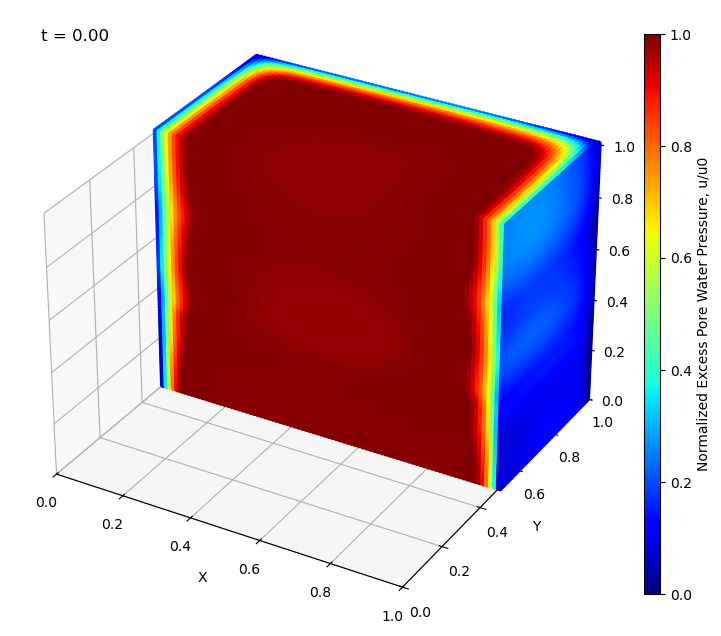

In [16]:
from matplotlib.animation import FuncAnimation

# Grid and time parameters
N = 90  # Grid size
Nx = Ny = Nz = N
Nt = 21600  # Number of time steps

v_min, v_max = 0., 1.0  # Change for mesh-free evaluation
ts = np.linspace(0, 1.0, Nt)

xs = np.linspace(v_min, v_max, N)
ys = np.linspace(v_min, v_max, N)
zs = np.linspace(v_min, v_max, N)

# Meshgrid for 3D evaluation
Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')

# Flatten data for 3D plotting
x_flat = Xtest.flatten()
y_flat = Ytest.flatten()
z_flat = Ztest.flatten()

# Initialize figure and axis
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})

# Initial plot
scatter = ax.scatter([], [], [], c=[], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)

# Set axis limits
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Animation parameters
fps = 30
t_val = 5.0
num_frames = fps * t_val
interval = 1000 / fps

start_time = time.time()

# Add a text label for time
t_text = ax.text2D(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, color='black')

def update(frame):
    # Calculate time elapsed per frame
    elapsed_time = time.time() - start_time
    average_time_per_frame = elapsed_time / (frame + 1)
    
    # Estimate remaining time
    remaining_time = average_time_per_frame * (num_frames - frame - 1)

    # Print predicted time remaining
    progress_message = f"Frame {frame+1}/{num_frames}, Predicted time remaining: {remaining_time:.2f} seconds"

    print(progress_message)
    
    # Calculate time index dynamically
    t_index = int((frame / num_frames) * (Nt - 1))  # Varies from 0 to Nt-1

    # Fixed cv values
    cv1_val, cv2_val, cv3_val = 0.02, 0.05, 0.08

    cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
    cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
    cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val

    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(),  ts[t_index]), cv1_arr, cv2_arr, cv3_arr]
    
    # Placeholder for model evaluation (replace with actual function)
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)

    p_flat = p_pred_fixed_time.flatten()
    mask = (y_flat >= 0.5) & (y_flat <= 1.0)

    # Update scatter plot data
    scatter._offsets3d = x_flat[mask], y_flat[mask], z_flat[mask]
    scatter.set_array(p_flat[mask])
    
    # Update the cv text
    current_t = f't = {ts[t_index]:.2f}'
    t_text.set_text(current_t)
    
    return scatter, current_t

# Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(0, num_frames), interval=interval, blit=False)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(scatter, cax=cbar_ax, label='Normalized Excess Pore Water Pressure, u/u0')

# Save or display the animation
ani.save(f"3D-Animation_time_60fps.gif", dpi=80)

print(f'Animation completed.')

#### MSE Loss vs Time (Table)

In [8]:
# Initialize a list to store average MSE losses for each time point
average_mse_losses = []

# Iterate over time points from 0.1 to 1.0 in steps of 0.1
time_points = np.linspace(0.1, 1.0, 10)

for time_point in time_points:
    print(f"Starting t = {time_point}")
    t_index = int(time_point * (21600 - 1))
    mse_values = []

    for cv1_val, cv2_val, cv3_val in choices:        
        # Load the exact solution for the given combination
        u_t = np.load(os.path.join(save_directory, f'u_t_{cv1_val}_{cv2_val}_{cv3_val}_{N}_{time_point:.1f}.npy'))

        # Prepare inputs for the model
        cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
        cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
        cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val

        input_test = [
            Xtest.flatten(),
            Ytest.flatten(),
            Ztest.flatten(),
            np.full_like(Xtest.flatten(), ts[t_index]),
            cv1_arr,
            cv2_arr,
            cv3_arr
        ]

        # Predict using the model
        p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)

        # Calculate the MSE for this combination
        mse = np.mean((p_pred_fixed_time - u_t) ** 2)
        mse_values.append(mse)

        del u_t
        gc.collect()

    # Compute the average MSE for the current time point
    average_mse = np.mean(mse_values)
    average_mse_losses.append((time_point, average_mse))

# Print the table of time points and average MSE losses
print(f"{'Time Point':<10} | {'Average MSE Loss':<15}")
print("-" * 30)
for time_point, avg_mse in average_mse_losses:
    print(f"{time_point:<10.1f} | {avg_mse:<15.6e}")

Starting t = 0.1
Starting t = 0.2
Starting t = 0.30000000000000004
Starting t = 0.4
Starting t = 0.5
Starting t = 0.6
Starting t = 0.7000000000000001
Starting t = 0.8
Starting t = 0.9
Starting t = 1.0
Time Point | Average MSE Loss
------------------------------
0.1        | 1.999201e-04   
0.2        | 3.252773e-04   
0.3        | 4.565213e-04   
0.4        | 5.623287e-04   
0.5        | 6.444722e-04   
0.6        | 7.078612e-04   
0.7        | 7.585189e-04   
0.8        | 8.010499e-04   
0.9        | 8.390732e-04   
1.0        | 8.767983e-04   


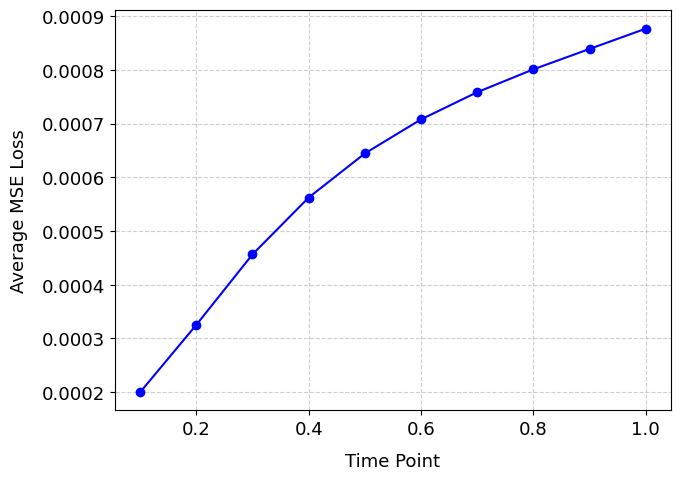

In [25]:
# Extract time points and average MSE losses from the calculated data
time_points = [item[0] for item in average_mse_losses]
mse_losses = [item[1] for item in average_mse_losses]

plt.rcParams.update({'font.size': 13})  # Adjust the font size globally

# Plot the MSE loss against the time points
plt.figure(figsize=(7, 5))
plt.plot(time_points, mse_losses, marker='o', linestyle='-', color='b', label='Average MSE Loss')
plt.xlabel('Time Point', fontsize=13,labelpad=10)
plt.ylabel('Average MSE Loss', fontsize=13,labelpad=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot
plt.savefig("./plots/MSE_Loss_vs_Time.png", dpi=600, bbox_inches='tight')
plt.show()

## MSE Plot:

#### All time points:

11 remaining
10 remaining
9 remaining
8 remaining
7 remaining
6 remaining
5 remaining
4 remaining
3 remaining
2 remaining


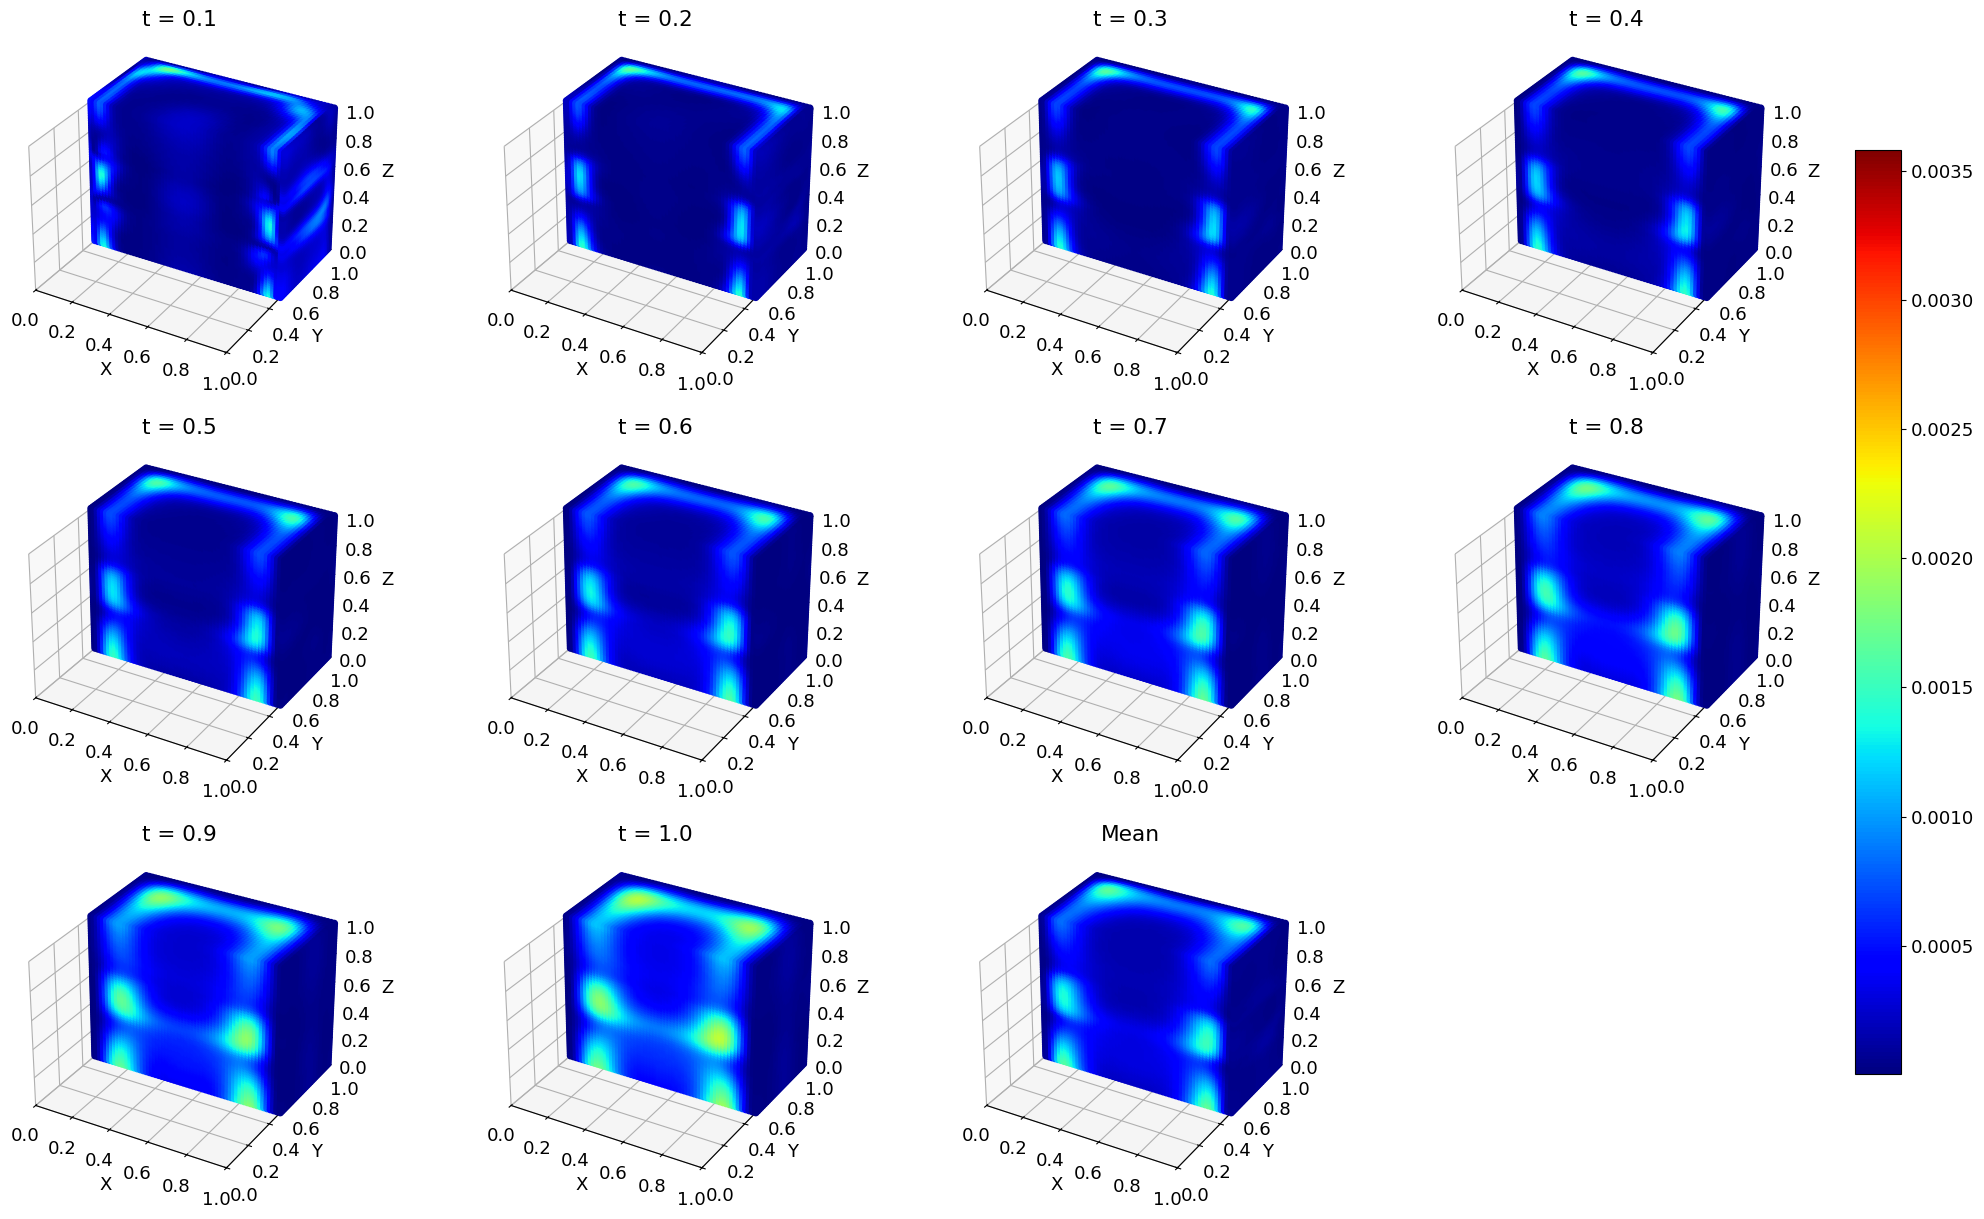

In [24]:
# Iterate over time points from 0.1 to 1.0 in steps of 0.1
time_points = np.linspace(0.1, 1.0, 10)
all_mse_arrays = []

# Create a figure with a grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(30, 15), subplot_kw={'projection': '3d'}, gridspec_kw={'hspace': 0.2, 'wspace': 0.01})

for idx, time_point in enumerate(time_points):
    t_index = int(time_point*(21600-1))
    squared_differences = []

    for i, (cv1_val, cv2_val, cv3_val) in enumerate(choices):
        u_t = np.load(os.path.join(save_directory, f'u_t_{cv1_val}_{cv2_val}_{cv3_val}_{N}_{time_point:.1f}.npy'))

        cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
        cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
        cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val

        input_test = [
            Xtest.flatten(),
            Ytest.flatten(),
            Ztest.flatten(),
            np.full_like(Xtest.flatten(), ts[t_index]),
            cv1_arr,
            cv2_arr,
            cv3_arr
        ]

        # Evaluate model predictions at the specific time point
        p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)

        # Calculate the difference/errors
        difference = p_pred_fixed_time - u_t

        # Square the differences and append to the list
        squared_differences.append(difference**2)

        del u_t
        gc.collect()

    # Calculate the mean squared error (MSE) 3D array for the current time point
    mse_3d_array = np.mean(squared_differences, axis=0)
    all_mse_arrays.append(mse_3d_array)

    # Plot the MSE values for the current time point
    mse_flat = mse_3d_array.flatten()
    mse_masked = mse_flat[mask]

    ax = axes[idx // 4, idx % 4]
    scatter_plot_mse = ax.scatter(
        x_flat[mask], y_flat[mask], z_flat[mask], c=mse_masked, cmap='jet', marker='o', alpha=1.
    )

    ax.set_title(f't = {time_point:.1f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])

    print(f"{11-idx} remaining")

# Calculate the mean MSE array across all time points
mean_mse_array = np.mean(all_mse_arrays, axis=0)

# Plot the mean MSE array
mean_mse_flat = mean_mse_array.flatten()
mean_mse_masked = mean_mse_flat[mask]

ax_mean = axes[2, 2]  # Change this to place the mean plot in the last row, 3rd column
scatter_plot_mean = ax_mean.scatter(
    x_flat[mask], y_flat[mask], z_flat[mask], c=mean_mse_masked, cmap='jet', marker='o', alpha=1.
)

ax_mean.set_title('Mean')
ax_mean.set_xlabel('X')
ax_mean.set_ylabel('Y')
ax_mean.set_zlabel('Z')
ax_mean.set_xlim([0, 1])
ax_mean.set_ylim([0, 1])
ax_mean.set_zlim([0, 1])

# Adjust layout and add colorbar
fig.colorbar(scatter_plot_mse, ax=axes, orientation='vertical', shrink=0.8, pad=0.034)

axes.flat[-1].set_visible(False)  # to remove blank plot

# Save the combined MSE plot
plt.savefig(f"./plots/3D-MSE-Plots-All-Time-Points-And-Mean.png", dpi=600, bbox_inches='tight')
plt.show()

#### One time point:

In [ ]:
# Initialize an array to store squared differences
squared_differences = []

for i, (cv1_val, cv2_val, cv3_val) in enumerate(choices):
    u_t = np.load(os.path.join(save_directory, f'u_t_{cv1_val}_{cv2_val}_{cv3_val}_{N}_0.5.npy'))

    cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
    cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
    cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val

    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv1_arr, cv2_arr, cv3_arr]
    
    # Evaluate model predictions at the specific time point
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)

    # Calculate the difference/errors
    difference = p_pred_fixed_time - u_t

    # Square the differences and append to the list
    squared_differences.append(difference**2)
    
    del u_t
    
    gc.collect()
    
# Calculate the mean squared error (MSE) 3D array
mse_3d_array = np.mean(squared_differences, axis=0)
print("MSE 3D array calculated.")

mse_flat = mse_3d_array.flatten()
mse_masked = mse_flat[mask]

# Plot the MSE values
fig_mse = plt.figure(figsize=(5, 3.5))
ax_mse = fig_mse.add_subplot(111, projection='3d')

scatter_plot_mse = ax_mse.scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=mse_masked, cmap='jet', marker='o', alpha=1.)

ax_mse.set_title('Mean Squared Error (MSE) Plot')
ax_mse.set_xlabel('X')
ax_mse.set_ylabel('Y')
ax_mse.set_zlabel('Z')
ax_mse.set_xlim([0, 1])
ax_mse.set_ylim([0, 1])
ax_mse.set_zlim([0, 1])
fig_mse.colorbar(scatter_plot_mse, ax=ax_mse, shrink=0.8, pad=0.15)

# Save the MSE plot
plt.savefig(f"./plots/3D-MSE-Plot.png", dpi=600)
plt.show()

## Inversion

### Single Inversion Testing:

In [31]:
N = 60

# Define the evaluation grid
xs = np.linspace(0, 1, N)
ys = np.linspace(0, 1, N)
zs = np.linspace(0, 1, N)
ts = np.linspace(0, 1, 21600)

Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')
x_flat = Xtest.flatten()
y_flat = Ytest.flatten()
z_flat = Ztest.flatten()

In [37]:
# ---------------- Loading Data -----------------
fast = True

cv1_test, cv2_test, cv3_test = 0.02, 0.04, 0.08
N = 60
time_point = 0.7
t_index = int(time_point*(21600-1))

if fast:
    save_directory = '/rds/general/user/us322/ephemeral/3D Layered Testing Time'
    os.makedirs(save_directory, exist_ok=True)
    
    u_t = np.load(os.path.join(save_directory, f'u_t_{cv1_test}_{cv2_test}_{cv3_test}_{N}_{time_point}.npy'))

    xs = np.linspace(0, 1, N)
    ys = np.linspace(0, 1, N)
    zs = np.linspace(0, 1, N)
    ts = np.linspace(0, 1, 21600)

    Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')

else:
    save_directory = '/rds/general/user/us322/ephemeral/3D Layered Testing'
    os.makedirs(save_directory, exist_ok=True)
    
    u_loaded = np.load(os.path.join(save_directory, f'3D_Layered_{cv1_test}_{cv2_test}_{cv3_test}_{N}.npy'))

    random_time_steps = np.random.choice(np.arange(1, 21600), size=100, replace=False)
    random_time_steps.sort()  # Sort to maintain order if needed
    
    # Extract the corresponding time slices from u_loaded
    u_t = u_loaded[:, :, :, random_time_steps]
    
    # Define spatial and temporal coordinates
    xs = np.linspace(0, 1, u_loaded.shape[0])
    ys = np.linspace(0, 1, u_loaded.shape[1])
    zs = np.linspace(0, 1, u_loaded.shape[2])
    ts = np.linspace(0, 1, 21600)
    
    del u_loaded
    gc.collect()
    
    # Create meshgrid for test data
    Xtest, Ytest, Ztest, Ttest = np.meshgrid(xs, ys, zs, ts[random_time_steps], indexing='ij')

Optimized cv1 = 0.026758, cv2 = 0.038404, cv3 = 0.082729
Accuracy for cv1: 66.21%
Accuracy for cv2: 96.01%
Accuracy for cv3: 96.59%
Average time taken to perform inverison: 7.8537 seconds


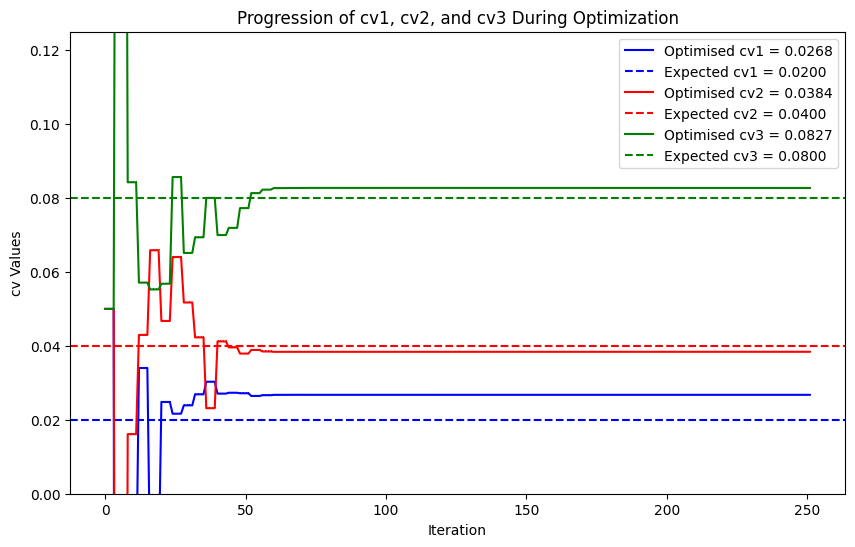

In [38]:
cv1_tested, cv2_tested, cv3_tested = [],[],[]

def error_function(cv_values):
    cv1_val, cv2_val, cv3_val = cv_values
    
    # Log the current cv values for plotting
    cv1_tested.append(cv1_val)
    cv2_tested.append(cv2_val)
    cv3_tested.append(cv3_val)
    
    cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
    cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
    cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val

    if fast:    
        input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]),
                      cv1_arr, cv2_arr, cv3_arr]
    else:
        input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), Ttest.flatten(), cv1_arr, cv2_arr, cv3_arr]
    
    pd_eval = pd.eval(input_test).reshape(Xtest.shape)
    
    # Calculate the error between pd_eval and exact solution u_t
    return np.mean((pd_eval - u_t)**2)

initial_guess = [0.05, 0.05, 0.05]

options = {'eps': 1e-5}  # Gradient tolerance and step size

# Perform optimization
start_time = time.time()

result = minimize(error_function, initial_guess, method='BFGS', options=options)

end_time = time.time()
elapsed_time = end_time - start_time

best_cv1, best_cv2, best_cv3 = result.x

accuracy_cv1 = 100 * (1 - np.abs(best_cv1 - cv1_test) / cv1_test)
accuracy_cv2 = 100 * (1 - np.abs(best_cv2 - cv2_test) / cv2_test)
accuracy_cv3 = 100 * (1 - np.abs(best_cv3 - cv3_test) / cv3_test)

# Print optimized values
print(f"Optimized cv1 = {best_cv1:.6f}, cv2 = {best_cv2:.6f}, cv3 = {best_cv3:.6f}")
print(f"Accuracy for cv1: {accuracy_cv1:.2f}%")
print(f"Accuracy for cv2: {accuracy_cv2:.2f}%")
print(f"Accuracy for cv3: {accuracy_cv3:.2f}%")

print(f"Average time taken to perform inverison: {elapsed_time:.4f} seconds")

# Plot the values of cv1, cv2, and cv3 over iterations
plt.figure(figsize=(10, 6))
plt.plot(cv1_tested, marker=',', label=f'Optimised cv1 = {best_cv1:.4f}', color='b')
plt.axhline(y=cv1_test, linestyle='--', label=f'Expected cv1 = {cv1_test:.4f}', color='b')
plt.plot(cv2_tested, marker=',', label=f'Optimised cv2 = {best_cv2:.4f}', color='r')
plt.axhline(y=cv2_test, linestyle='--', label=f'Expected cv2 = {cv2_test:.4f}', color='r')
plt.plot(cv3_tested, marker=',', label=f'Optimised cv3 = {best_cv3:.4f}', color='g')
plt.axhline(y=cv3_test, linestyle='--', label=f'Expected cv3 = {cv3_test:.4f}', color='g')

# Add dashed lines for true Cv values
plt.xlabel("Iteration")
plt.ylabel("cv Values")
plt.title("Progression of cv1, cv2, and cv3 During Optimization")
plt.legend()
plt.ylim(0.0,0.125)
plt.show()

### Determining the accuracies with time

In [30]:
choices = [
    (cv1, cv2, cv3)
    for cv1 in (0.02, 0.04, 0.06, 0.08)
    for cv2 in (0.02, 0.04, 0.06, 0.08)
    for cv3 in (0.02, 0.04, 0.06, 0.08)
    if cv1 != cv2 and cv1 != cv3 and cv2 != cv3
]

initial_guess = [0.05, 0.05, 0.05]
options = {'eps': 1e-5}  # Gradient tolerance and step size
overall_accuracies_cv1, overall_accuracies_cv2, overall_accuracies_cv3 = [], [], []

for time_point in np.arange(0.1, 1.1, 0.1):
    accuracies_cv1, accuracies_cv2, accuracies_cv3, inversion_times = [],[],[],[]
    t_index = int(time_point*(21600-1))
    
    for i, (cv1_val, cv2_val, cv3_val) in enumerate(choices):
        cv1_tested, cv2_tested, cv3_tested = [],[],[]
    
        u_t = np.load(os.path.join(save_directory, f'u_t_{cv1_val}_{cv2_val}_{cv3_val}_{N}_{time_point}.npy'))
    
        start_time=time.time() #
        result = minimize(error_function, initial_guess, method='BFGS')#, options=options)
        end_time=time.time() #
    
        time_taken = end_time - start_time
        inversion_times.append(time_taken)
    
        best_cv1, best_cv2, best_cv3 = result.x
    
        accuracy_cv1 = 100 * (1 - np.abs(best_cv1 - cv1_val) / cv1_val)
        accuracy_cv2 = 100 * (1 - np.abs(best_cv2 - cv2_val) / cv2_val)
        accuracy_cv3 = 100 * (1 - np.abs(best_cv3 - cv3_val) / cv3_val)
    
        # Append the accuracies to the arrays
        accuracies_cv1.append(accuracy_cv1)
        accuracies_cv2.append(accuracy_cv2)
        accuracies_cv3.append(accuracy_cv3)

        print(f"cv1: {accuracy_cv1:.2f}%, cv2: {accuracy_cv2:.2f}%, cv3: {accuracy_cv3:.2f}%")
        
        del u_t
        gc.collect()
    
    # Calculate and print average inversion time
    avg_inversion_time = np.mean(inversion_times)
    
    # Calculate average accuracies
    avg_accuracy_cv1 = np.mean(accuracies_cv1)
    avg_accuracy_cv2 = np.mean(accuracies_cv2)
    avg_accuracy_cv3 = np.mean(accuracies_cv3)

    # Append average accuracies to their respective arrays
    overall_accuracies_cv1.append(avg_accuracy_cv1)
    overall_accuracies_cv2.append(avg_accuracy_cv2)
    overall_accuracies_cv3.append(avg_accuracy_cv3)
    
    print(f"Average inversion time: {avg_inversion_time:.2f} seconds")
    
    print(f"Average accuracy for cv1: {avg_accuracy_cv1:.2f}%")
    print(f"Average accuracy for cv2: {avg_accuracy_cv2:.2f}%")
    print(f"Average accuracy for cv3: {avg_accuracy_cv3:.2f}%")
    print("")

# Calculate and print the overall average accuracy for each cv1, cv2, and cv3
final_avg_accuracy_cv1 = np.mean(overall_accuracies_cv1)
final_avg_accuracy_cv2 = np.mean(overall_accuracies_cv2)
final_avg_accuracy_cv3 = np.mean(overall_accuracies_cv3)

print(f"Final overall average accuracy for cv1: {final_avg_accuracy_cv1:.2f}%")
print(f"Final overall average accuracy for cv2: {final_avg_accuracy_cv2:.2f}%")
print(f"Final overall average accuracy for cv3: {final_avg_accuracy_cv3:.2f}%")

cv1: 87.14%, cv2: 88.70%, cv3: 92.46%
cv1: -297.04%, cv2: 33.90%, cv3: 64.48%
cv1: 92.29%, cv2: 84.36%, cv3: 92.13%
cv1: 78.73%, cv2: 80.50%, cv3: 91.40%
cv1: 87.06%, cv2: 89.09%, cv3: 97.12%
cv1: 88.23%, cv2: 93.00%, cv3: 83.41%
cv1: 99.08%, cv2: 88.98%, cv3: 90.28%
cv1: 93.66%, cv2: 59.95%, cv3: 91.12%
cv1: 81.80%, cv2: -146.67%, cv3: -1305.26%
cv1: 99.38%, cv2: 94.97%, cv3: 94.48%
cv1: 92.67%, cv2: -57.24%, cv3: -1248.24%



KeyboardInterrupt



#### Relative Errors

In [ ]:
# Loop through different time points to plot 3D contours
fig, axs = plt.subplots(len(choices), 3, figsize=(15, 5 * len(choices)), subplot_kw={'projection': '3d'})

difference_plot = True

for i, (cv1_val, cv2_val, cv3_val) in enumerate(choices):
    # Meshgrid for 3D evaluation
    cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
    cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
    cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val

    input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv1_arr, cv2_arr, cv3_arr]

    # Evaluate model predictions at the specific time point
    p_pred_fixed_time = pd.eval(input_test).reshape(Xtest.shape)

    # Flatten data for 3D plotting
    p_flat = p_pred_fixed_time.flatten()
    
    # Plotting PINN result
    scatter_plot_0 = axs[i, 0].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=p_flat[mask], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
    axs[i, 0].set_title(f'PINN Solution for ({cv1_val},{cv2_val},{cv3_val})')
    axs[i, 0].set_xlabel('X')
    axs[i, 0].set_ylabel('Y')
    axs[i, 0].set_zlabel('Z')
    axs[i, 0].set_xlim([0, 1])
    axs[i, 0].set_ylim([0, 1])
    axs[i, 0].set_zlim([0, 1])
    fig.colorbar(scatter_plot_0, ax=axs[i, 0], shrink=0.8, pad=0.15)

    if difference_plot:
        u_t = np.load(os.path.join(save_directory, f'u_t_{cv1_val}_{cv2_val}_{cv3_val}_{N}.npy'))
        
        # Calculate the difference/errors
        difference = np.abs(p_pred_fixed_time - u_t)/np.abs(np.max(u_t))
        u_flat = u_t.flatten()
        d_flat = difference.flatten()
        
        # Plotting exact solution
        scatter_plot_1 = axs[i, 1].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=u_flat[mask], cmap='jet', marker='o', alpha=1., vmin=0, vmax=1)
        axs[i, 1].set_title(f'Exact Solution for ({cv1_val},{cv2_val},{cv3_val})')
        axs[i, 1].set_xlabel('X')
        axs[i, 1].set_ylabel('Y')
        axs[i, 1].set_zlabel('Z')
        axs[i, 1].set_xlim([0, 1])
        axs[i, 1].set_ylim([0, 1])
        axs[i, 1].set_zlim([0, 1])
        fig.colorbar(scatter_plot_1, ax=axs[i, 1], shrink=0.8, pad=0.15)
    
        # Plotting difference/errors
        scatter_plot_2 = axs[i, 2].scatter(x_flat[mask], y_flat[mask], z_flat[mask], c=d_flat[mask], cmap='jet', marker='o', alpha=1.)
        axs[i, 2].set_title(f'Rel. Error for cv = ({cv1_val},{cv2_val},{cv3_val})')
        axs[i, 2].set_xlabel('X')
        axs[i, 2].set_ylabel('Y')
        axs[i, 2].set_zlabel('Z')
        axs[i, 2].set_xlim([0, 1])
        axs[i, 2].set_ylim([0, 1])
        axs[i, 2].set_zlim([0, 1])
        fig.colorbar(scatter_plot_2, ax=axs[i, 2], shrink=0.8, pad=0.15)

        del u_t

        gc.collect()

plt.savefig(f"./plots/3D-Contour-Plots_Final_{epochs}.png")
plt.show()

### Error Analysis

In [20]:
N = 3
cv1_val = cv2_val = cv3_val = 0.055
t_index = int(0.5*(21600-1))

# Define the evaluation grid
xs = np.linspace(0, 1, N)
ys = np.linspace(0, 1, N)
zs = np.linspace(0, 1, N)
ts = np.linspace(0, 1, 21600)

Xtest, Ytest, Ztest = np.meshgrid(xs, ys, zs, indexing='ij')
x_flat = Xtest.flatten()
y_flat = Ytest.flatten()
z_flat = Ztest.flatten()

cv1_list = cv2_list = cv3_list = np.linspace(0.01,0.1,50)

RMSE_arr1, RMSE_arr2, RMSE_arr3 = [], [], []

# Start the timer
start_time = time.time()

with open(f"RMSE_log_{N}.txt", "a") as log_file:
    # Loop for cv1_list
    for i, cv1_iter in enumerate(cv1_list):
        loop_start_time = time.time()
    
        cv1_arr = np.ones_like(Xtest.flatten()) * cv1_iter
        cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
        cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val
    
        input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv1_arr, cv2_arr, cv3_arr]
        pd_eval = pd.eval(input_test).reshape(Xtest.shape)
    
        u_t = exactlayered(N, cv1_iter, cv2_val, cv3_val)[:,:,:,t_index]
    
        RMSE1 = np.mean((pd_eval - u_t)**2)
    
        del u_t, pd_eval
        gc.collect()
    
        RMSE_arr1.append(RMSE1)
    
        # Estimate remaining time
        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / (i + 1)
        remaining_iterations = (len(cv1_list) - (i + 1)) + len(cv2_list) + len(cv3_list)
        remaining_time = avg_time_per_iteration * remaining_iterations
    
        print(f"cv1 loop - Time taken: {time.time() - loop_start_time:.2f} seconds, Estimated time remaining: {remaining_time / 60:.2f} minutes")
        log_file.write(f"cv1 loop - Time taken: {time.time() - loop_start_time:.2f} seconds, Estimated time remaining: {remaining_time / 60:.2f} minutes\n")
        log_file.flush()  # Force immediate write to the file

    # Repeat for cv2_list
    for i, cv2_iter in enumerate(cv2_list):
        loop_start_time = time.time()
    
        cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
        cv2_arr = np.ones_like(Xtest.flatten()) * cv2_iter
        cv3_arr = np.ones_like(Xtest.flatten()) * cv3_val
    
        input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv1_arr, cv2_arr, cv3_arr]
        pd_eval = pd.eval(input_test).reshape(Xtest.shape)
    
        u_t = exactlayered(N, cv1_val, cv2_iter, cv3_val)[:,:,:,t_index]
    
        RMSE2 = np.mean((pd_eval - u_t)**2)
    
        del u_t, pd_eval
        gc.collect()
    
        RMSE_arr2.append(RMSE2)
    
        # Estimate remaining time
        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / (len(cv1_list) + i + 1)
        remaining_iterations = (len(cv2_list) - (i + 1)) + len(cv3_list)
        remaining_time = avg_time_per_iteration * remaining_iterations
    
        print(f"cv2 loop - Time taken: {time.time() - loop_start_time:.2f} seconds, Estimated time remaining: {remaining_time / 60:.2f} minutes")
        log_file.write(f"cv2 loop - Time taken: {time.time() - loop_start_time:.2f} seconds, Estimated time remaining: {remaining_time / 60:.2f} minutes\n")
        log_file.flush()  # Force immediate write to the file

    # Repeat for cv3_list
    for i, cv3_iter in enumerate(cv3_list):
        loop_start_time = time.time()
    
        cv1_arr = np.ones_like(Xtest.flatten()) * cv1_val
        cv2_arr = np.ones_like(Xtest.flatten()) * cv2_val
        cv3_arr = np.ones_like(Xtest.flatten()) * cv3_iter
    
        input_test = [Xtest.flatten(), Ytest.flatten(), Ztest.flatten(), np.full_like(Xtest.flatten(), ts[t_index]), cv1_arr, cv2_arr, cv3_arr]
        pd_eval = pd.eval(input_test).reshape(Xtest.shape)
    
        u_t = exactlayered(N, cv1_val, cv2_val, cv3_iter)[:,:,:,t_index]
        
        RMSE3 = np.mean((pd_eval - u_t)**2)
    
        del u_t, pd_eval
        gc.collect()
    
        RMSE_arr3.append(RMSE3)
    
        # Estimate remaining time
        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / (len(cv1_list) + len(cv2_list) + i + 1)
        remaining_iterations = len(cv3_list) - (i + 1)
        remaining_time = avg_time_per_iteration * remaining_iterations
    
        print(f"cv3 loop - Time taken: {time.time() - loop_start_time:.2f} seconds, Estimated time remaining: {remaining_time / 60:.2f} minutes")
        log_file.write(f"cv3 loop - Time taken: {time.time() - loop_start_time:.2f} seconds, Estimated time remaining: {remaining_time / 60:.2f} minutes\n")
        log_file.flush()  # Force immediate write to the file

np.savez(f'./rmse/RMSE_data_{N}.npz', RMSE_arr1=RMSE_arr1, RMSE_arr2=RMSE_arr2, RMSE_arr3=RMSE_arr3)

plt.plot(cv1_list, RMSE_arr1, label='cv1')
plt.plot(cv2_list, RMSE_arr2, label='cv2')
plt.plot(cv3_list, RMSE_arr3, label='cv3')

# Adding vertical bars
plt.axvline(x=0.01, color='blue', linestyle='--')
plt.axvline(x=0.055, color='blue', linestyle='--')
plt.axvline(x=0.10, color='blue', linestyle='--')

plt.legend()
plt.xlabel('cv1/cv2/cv3')
plt.ylabel('RMSE')
plt.grid()
plt.savefig('./rmse/ContinuousRMSE.png',dpi=600)
plt.show()

Simulation completed for (0.01, 0.055, 0.055)
cv1 loop - Time taken: 0.40 seconds, Estimated time remaining: 0.99 minutes
Simulation completed for (0.01183673469387755, 0.055, 0.055)
cv1 loop - Time taken: 0.39 seconds, Estimated time remaining: 1.00 minutes
Simulation completed for (0.013673469387755103, 0.055, 0.055)
cv1 loop - Time taken: 0.40 seconds, Estimated time remaining: 0.99 minutes
Simulation completed for (0.015510204081632653, 0.055, 0.055)
cv1 loop - Time taken: 0.40 seconds, Estimated time remaining: 0.98 minutes
Simulation completed for (0.017346938775510204, 0.055, 0.055)
cv1 loop - Time taken: 0.40 seconds, Estimated time remaining: 0.97 minutes
Simulation completed for (0.019183673469387756, 0.055, 0.055)
cv1 loop - Time taken: 0.40 seconds, Estimated time remaining: 0.96 minutes
Simulation completed for (0.02102040816326531, 0.055, 0.055)
cv1 loop - Time taken: 0.40 seconds, Estimated time remaining: 0.95 minutes
Simulation completed for (0.02285714285714286, 0.055

KeyboardInterrupt: 